In [140]:
import tensorflow as tf
import tensorflow_datasets as tfds

In [141]:
#Descargar set de datos de Fashion MNIST de Zalando
datos, metadatos = tfds.load('fashion_mnist', as_supervised=True, with_info=True)

In [162]:
#Obtenemos en variables separadas los datos de entrenamiento (60k) y pruebas (10k)
datos_entrenamiento, datos_pruebas = datos['train'], datos['test']

In [ ]:
#Etiquetas de las 10 categorias posibles
nombres_clases = metadatos.features['label'].names
nombres_clases

In [164]:
#Funcion de normalizacion para los datos (Pasar de 0-255 a 0-1)
#Hace que la red aprenda mejor y mas rapido
def normalizar(imagenes, etiquetas):
  imagenes = tf.cast(imagenes, tf.float32)
  imagenes /= 255 #Aqui lo pasa de 0-255 a 0-1
  return imagenes, etiquetas

#Normalizar los datos de entrenamiento y pruebas con la funcion que hicimos
datos_entrenamiento = datos_entrenamiento.map(normalizar)
datos_pruebas = datos_pruebas.map(normalizar)

#Agregar a cache (usar memoria en lugar de disco, entrenamiento mas rapido)
datos_entrenamiento = datos_entrenamiento.cache()
datos_pruebas = datos_pruebas.cache()

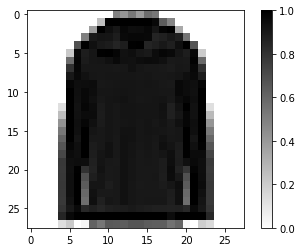

In [169]:
import matplotlib.pyplot as plt
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
imagenes = []
for imagen, etiqueta in datos_entrenamiento.take(4):
  imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues
  imagenes.append(imagen)



#Dibujar dibujar
plt.figure()
plt.imshow(imagen, cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show()

primeros 25 datos de entrenamiento


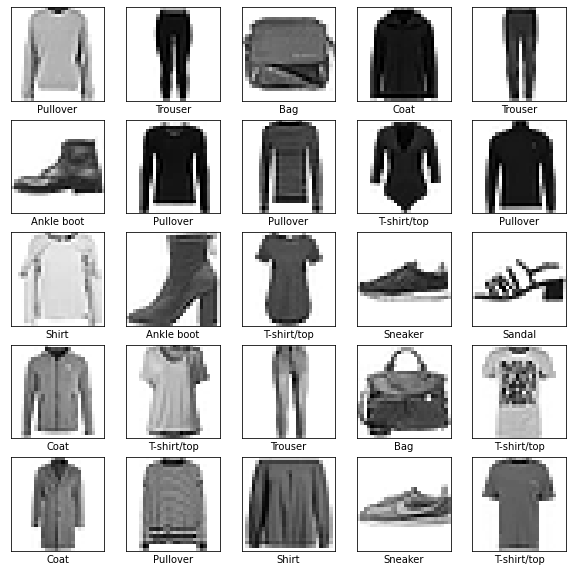

primeros 25 datos de prueba


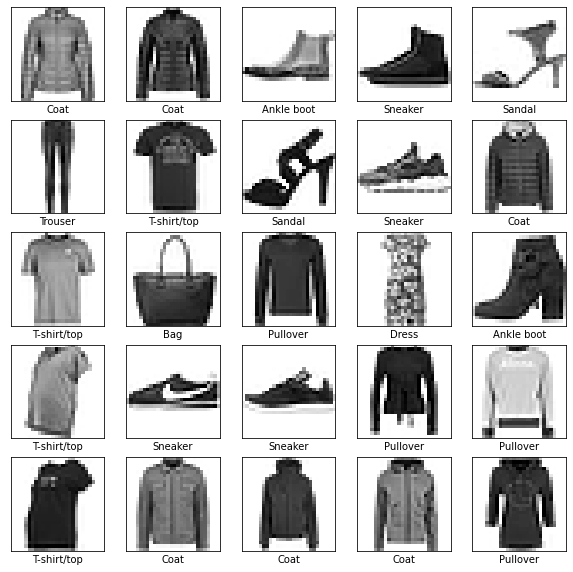

In [168]:
print("primeros 25 datos de entrenamiento")
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_entrenamiento.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

print("primeros 25 datos de prueba")
plt.figure(figsize=(10,10))
for i, (imagen, etiqueta) in enumerate(datos_pruebas.take(25)):
  imagen = imagen.numpy().reshape((28,28))
  plt.subplot(5,5,i+1)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(imagen, cmap=plt.cm.binary)
  plt.xlabel(nombres_clases[etiqueta])
plt.show()

In [147]:
#Crear el modelo
modelo = tf.keras.Sequential([
  tf.keras.layers.Flatten(input_shape=(28,28,1)), #1 - blanco y negro
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(50, activation=tf.nn.relu),
  tf.keras.layers.Dense(10, activation=tf.nn.softmax) #Para redes de clasificacion
])

In [148]:
#Compilar el modelo
modelo.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
)

In [149]:
#Los numeros de datos en entrenamiento y pruebas (60k y 10k)
num_ej_entrenamiento = metadatos.splits["train"].num_examples
num_ej_pruebas = metadatos.splits["test"].num_examples

In [150]:
#El trabajo por lotes permite que entrenamientos con gran cantidad de datos se haga de manera mas eficiente
TAMANO_LOTE = 32

#Shuffle y repeat hacen que los datos esten mezclados de manera aleatoria para que la red
#no se vaya a aprender el orden de las cosas
datos_entrenamiento = datos_entrenamiento.repeat().shuffle(num_ej_entrenamiento).batch(TAMANO_LOTE)
datos_pruebas = datos_pruebas.batch(TAMANO_LOTE)

In [151]:
import math

#Entrenar
historial = modelo.fit(datos_entrenamiento, epochs=5, steps_per_epoch= math.ceil(num_ej_entrenamiento/TAMANO_LOTE))

Epoch 1/5
1875/1875 [==============================] - 11s 3ms/step - loss: 0.5158 - accuracy: 0.8179
Epoch 2/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3839 - accuracy: 0.8601
Epoch 3/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3489 - accuracy: 0.8719
Epoch 4/5
1875/1875 [==============================] - 6s 3ms/step - loss: 0.3213 - accuracy: 0.8819
Epoch 5/5
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3058 - accuracy: 0.8866


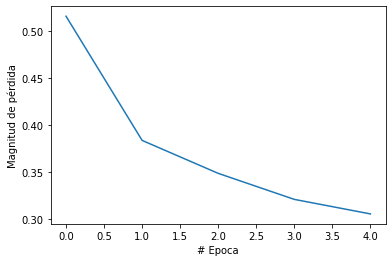

In [152]:
#Ver la funcion de perdida
plt.xlabel("# Epoca")
plt.ylabel("Magnitud de pérdida")
plt.plot(historial.history["loss"])

1/1 [==============================] - 0s 56ms/step


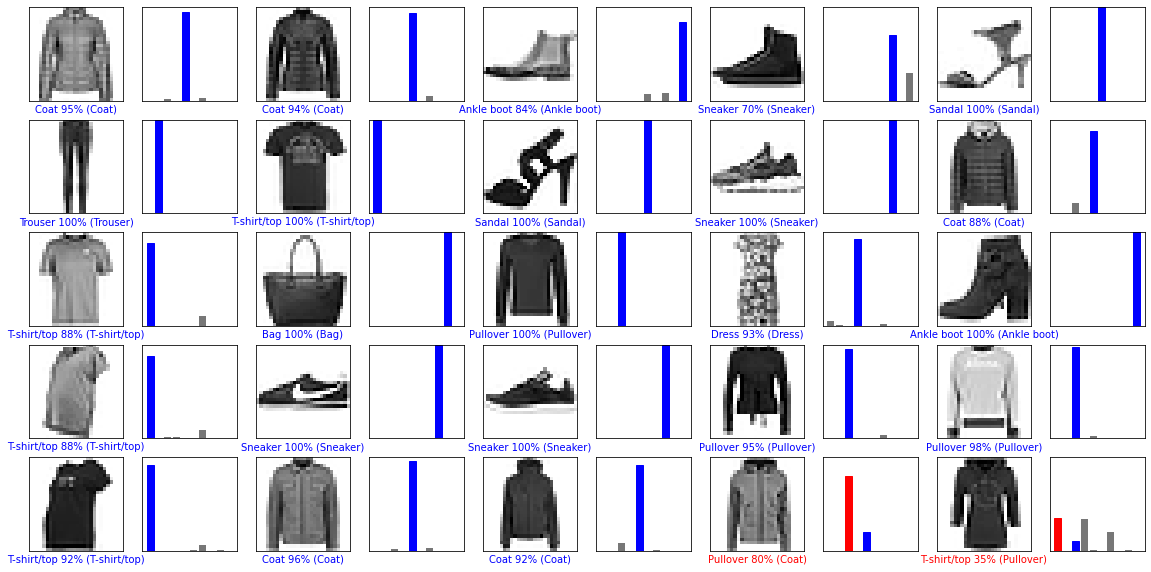

In [153]:
#Pintar una cuadricula con varias predicciones, y marcar si fue correcta (azul) o incorrecta (roja)
import numpy as np

for imagenes_prueba, etiquetas_prueba in datos_pruebas.take(1):
  imagenes_prueba = imagenes_prueba.numpy()
  etiquetas_prueba = etiquetas_prueba.numpy()
  predicciones = modelo.predict(imagenes_prueba)
  

def graficar_imagen(i, arr_predicciones, etiquetas_reales, imagenes):
  arr_predicciones, etiqueta_real, img = arr_predicciones[i], etiquetas_reales[i], imagenes[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  
  plt.imshow(img[...,0], cmap=plt.cm.binary)

  etiqueta_prediccion = np.argmax(arr_predicciones)
  if etiqueta_prediccion == etiqueta_real:
    color = 'blue'
  else:
    color = 'red'
  
  plt.xlabel("{} {:2.0f}% ({})".format(nombres_clases[etiqueta_prediccion],
                                100*np.max(arr_predicciones),
                                nombres_clases[etiqueta_real]),
                                color=color)
  
def graficar_valor_arreglo(i, arr_predicciones, etiqueta_real):
  arr_predicciones, etiqueta_real = arr_predicciones[i], etiqueta_real[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])
  grafica = plt.bar(range(10), arr_predicciones, color="#777777")
  plt.ylim([0, 1]) 
  etiqueta_prediccion = np.argmax(arr_predicciones)
  
  grafica[etiqueta_prediccion].set_color('red')
  grafica[etiqueta_real].set_color('blue')
  
filas = 5
columnas = 5
num_imagenes = filas*columnas
plt.figure(figsize=(2*2*columnas, 2*filas))
for i in range(num_imagenes):
  plt.subplot(filas, 2*columnas, 2*i+1)
  graficar_imagen(i, predicciones, etiquetas_prueba, imagenes_prueba)
  plt.subplot(filas, 2*columnas, 2*i+2)
  graficar_valor_arreglo(i, predicciones, etiquetas_prueba)

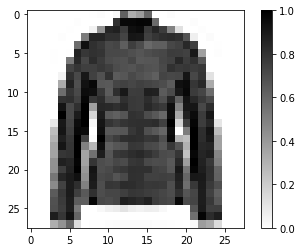

Etiqueta real=>Coat


In [177]:
import matplotlib.pyplot as plt
#Mostrar una imagen de los datos de pruebas, de momento mostremos la primera
imagenes = []
etiquetas = []
for imagen, etiqueta in datos_pruebas.take(30):
  imagen = imagen.numpy().reshape((28,28)) #Redimensionar, cosas de tensores, lo veremos despues
  imagenes.append(imagen)
  etiquetas.append(etiqueta)

z=1

#Dibujar dibujar
plt.figure()
plt.imshow(imagenes[z], cmap=plt.cm.binary)
plt.colorbar()
plt.grid(False)
plt.show() 
print("Etiqueta real=>"+nombres_clases[etiquetas[z]])

In [171]:
#Probar una imagen suelta
i=1
imagen = imagenes_prueba[i] #AL ser la variable imagenes_prueba solo tiene lo que se le puso en el bloque anterior heheh
imagen = np.array([imagen])
prediccion = modelo.predict(imagen)

print("Prediccion: " + nombres_clases[np.argmax(prediccion[0])])



1/1 [==============================] - 0s 71ms/step
Prediccion: Coat
